In [188]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import sqlite3
import warnings
import random
import sqlalchemy
from math import comb

# Make sure these are in the filepath.
import factorization
import sampling

In [85]:
# Import entire yt graph.
dcon = sqlite3.connect("yt_graph.db")
edges = pd.read_sql_query("SELECT * FROM ytGraphDirected", con=dcon)
G_full = nx.from_edgelist(edges.to_numpy())
dcon.close()

## Implementation.
These functions implement and evaluate the link prediction process.

In [1]:
# Remove perc edges, for evaluation.
# Does not mutate G.

# DOES NOT WORK FOR DIRECTED GRAPHS.
def remove_edges(G, perc=0.2):
    
    size = G.number_of_edges()
    
    # Num edges to remove.
    N = np.floor(0.2*size)
    
    # Initialize output.
    G_removed = G.copy()
    removed_edges = []
    bridges = []
    j = 0
    
    while (len(removed_edges) < N) and (j < size):
        
        # Don't choose edges from the list of known bridges.
        candidate_edges = list(set(G_removed.edges()) - set(bridges))
        edge = random.choice(candidate_edges)
        
        # Check if the selected edge is a bridge.
        G_removed.remove_edge(edge[0], edge[1])
        is_bridge = not nx.has_path(G_removed, edge[0], edge[1])
        
        if is_bridge:
            # If edge is a bridge, add it back to the graph and pass.
            # Also add it to list of bridges so it isn't selected again.
            G_removed.add_edge(edge[0], edge[1])
            bridges.append(edge)
        else:
            # Otherwise, don't add the edge back and append it to output.
            removed_edges.append(edge)
        
        j = j + 1
    
    # Return a new graph with edges remove, as well as what was removed.
    return G_removed, removed_edges

In [2]:
# This function calculates embeddings for G.
def calc_embeddings(G, directed=False, alg="factorization", sim="autocovariance"):
    # G -- nx.Graph, or nx.DiGraph (if directed==True)
    # Directed -- t/f
    # alg -- embedding algorithm -- "factorization", "sampling"
    # sim -- similarity metric -- "autocovariance", "PMI"
    warnings.filterwarnings('ignore')
    
    if alg == "factorization":
        
        # factorization.embed(G, dimensions=128, markov_time, directed, similarity, average_similarity)
        emb = factorization.embed(G, 128, 3, directed, sim, False)
        
    elif alg == "sampling":
        
        # sampling.embed(G, dimensions=128, markov_time, None, directed, similarity, average_similarity,
        #       lr, iter, early_stop, batch_size, neg, walks, walk_length, damp, workers)
        emb = sampling.embed(G, 128, 3, None, directed, sim, False,
                            6e-3, 50, 5, 100, 1, 10, 80, 0.85, 32)
        
    return emb[:, ~np.isnan(emb).any(axis=0)]

In [190]:
# Given a list of embeddings, return a list of top k predicted edges.
def link_prediction(G, emb, k):
    
    existing_edges = [(min(edge), max(edge)) for edge in G.edges()]
    vertices = sorted(list(G.nodes()))
    
    candidate_edges = [(u, v) for u in vertices for v in vertices]
    candidate_edges = [edge for edge in candidate_edges if
                       (edge[0] < edge[1])]
    candidate_edges = [edge for edge in candidate_edges if
                       (edge not in existing_edges)]
    
    dic = {}
    for j in range(len(vertices)):
        dic[vertices[j]] = emb[j, :]
        
    # I'm not sure if this should be sorted by asc or desc.
    predictions = sorted(candidate_edges,
                         key=lambda x: np.dot(dic[x[0]], dic[x[1]]), reverse=True)
    
    return predictions[0:k]

In [3]:
# Do everything: Remove edges, link prediction, and evaluate.
def eval_model(G, k, get_all_preds=False):
    G_removed, removed_edges = remove_edges(G)
    order = len(G_removed.nodes())
    size = len(G_removed.edges())
    
    # If this is true, return the whole list of predictions rather than the confusion matrix.
    if get_all_preds:
        k = comb(order, 2) - size
    
    # Make predictions.
    emb = calc_embeddings(G_removed)
    predictions = link_prediction(G_removed, emb, k)
    
    if get_all_preds:
        return predictions
            
    # Evaluate against removed_edges.
    removed_edges = [(min(edge), max(edge)) for edge in removed_edges]
    TP = len([edge for edge in predictions if (edge in removed_edges)])
    FP = len(predictions) - TP
    FN = len(removed_edges) - TP
    TN = comb(order, 2) - size - TP - FP - FN
            
    return [TP, FP, FN, TN]

In [4]:
# This function evaluates the model on many graphs of increasing order for fixed k.
def test_on_order(start_vertex, iters=10, size_cap=5000):
    
    warnings.filterwarnings('ignore') # Ignore warnings.
    
    # Connect to graph db.
    dcon = sqlite3.connect("yt_graph.db")
    
    # Init some things.
    order = -1
    Cmatrices = {}
    bads = {}
    vertices = pd.Series([start_vertex], name="vertex")
    
    for j in range(iters):
        
        # First, enlarge search by adding neighbors of the current subgraph.
        vertices.to_sql("vertexList", con=dcon, if_exists="replace")
        print("Executing SQL to expand target subgraph. (Initial vertex: " +
              str(start_vertex) + ")")
        neighbors = pd.read_sql_query(
        """
        SELECT DISTINCT
            x.v2
        FROM
            ytGraphUndirected x
        WHERE EXISTS (
            SELECT *
            FROM vertexList y
            WHERE y.vertex = x.v1
            OR y.vertex = x.v2
        )
        """, dcon)
        print("              SQL complete.")
        vertices = pd.Series(neighbors.squeeze(), name="vertex")
        
        # If subgraph is maximal (represents an entire connected component), stop.
        if len(vertices) == order:
            print("SUBGRAPH IS MAXIMAL AND CANNOT BE ENLARGED.")
            print("------------------------------------------------------> STOPPING TESTING.")
            break
        
        # If graph is too big, stop.
        order = len(vertices)
        if order > size_cap:
            print("ORDER OF SUBGRAPH (" + str(order) + ") HAS EXCEEDED SPECIFIED SIZE LIMIT OF " +
                  str(size_cap) + ".")
            print("------------------------------------------------------> STOPPING TESTING.")
            break
        
        # Otherwise, continue by trying to make embeddings.
        G = G_full.subgraph(list(vertices))
        size = len(G.edges())
        print("Calculating embeddings for subgraph of order " + str(order) + "...")
        
        try:
            # Try to evaluate the model.
            k = int(np.ceil(0.2*size))
            Cmatrices[(order, size-k)] = eval_model(G, k, get_all_preds=False)
            print("              Embeddings complete.")
            
        except Exception as E:
            # Otherwise, save the error as well as the graph that produced it.
            # We might need this for testing later.
            print("              Embeddings failed. Moving to next iteration.")
            bads[G] = str(E)
            
        print("------------------------------------------------------> Iteration " +
              str(j+1) + "/" + str(iters) +
              " complete.")
        
    
    dcon.close()
    return Cmatrices, bads

## Test 1: Evaluate predictions vs size of graph

In [242]:
# Setup.
num_trials = 5
num_iters = 15
sample_vertices = random.sample(G_full.nodes(), num_trials)
print(sample_vertices)

test_order_Cmatrices = {}
test_order_bads = {}

[14987, 10285, 12294, 46028, 2603]


In [243]:
# Run tests.
# Might take a while depending on test parameters.

for j in range(num_trials):
    Cmatrices, bads = test_on_order(start_vertex=sample_vertices[j], iters=num_iters)
    test_order_Cmatrices.update(Cmatrices)
    test_order_bads.update(bads)

Executing SQL to expand target subgraph. (Initial vertex: 14987)
              SQL complete.
Calculating embeddings for subgraph of order 3...
              Embeddings complete.
------------------------------------------------------> Iteration 1/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 14987)
              SQL complete.
Calculating embeddings for subgraph of order 31...
              Embeddings complete.
------------------------------------------------------> Iteration 2/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 14987)
              SQL complete.
Calculating embeddings for subgraph of order 55...
              Embeddings complete.
------------------------------------------------------> Iteration 3/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 14987)
              SQL complete.
Calculating embeddings for subgraph of order 114...
              Embeddings complete.
-----------------------------------------

              Embeddings complete.
------------------------------------------------------> Iteration 9/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 12294)
              SQL complete.
Calculating embeddings for subgraph of order 3620...
              Embeddings complete.
------------------------------------------------------> Iteration 10/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 12294)
              SQL complete.
ORDER OF SUBGRAPH (5692) HAS EXCEEDED SPECIFIED SIZE LIMIT OF 5000.
------------------------------------------------------> STOPPING TESTING.
Executing SQL to expand target subgraph. (Initial vertex: 46028)
              SQL complete.
Calculating embeddings for subgraph of order 2...
              Embeddings complete.
------------------------------------------------------> Iteration 1/15 complete.
Executing SQL to expand target subgraph. (Initial vertex: 46028)
              SQL complete.
Calculating embeddings for subgrap

In [246]:
test_order_Cmatrices.values()

dict_values([[0, 1, 0, 0], [3, 6, 6, 414], [2, 14, 14, 1391], [7, 36, 35, 6193], [45, 126, 125, 79622], [144, 366, 365, 647455], [136, 420, 419, 789974], [205, 469, 468, 1087667], [317, 685, 684, 2183585], [611, 1254, 1253, 5870157], [714, 1719, 1718, 11527730], [1, 12, 11, 276], [28, 93, 92, 11239], [40, 134, 133, 35043], [83, 213, 213, 187112], [93, 266, 265, 254626], [178, 375, 374, 442902], [269, 561, 560, 931686], [345, 761, 760, 1974756], [549, 1270, 1270, 6464236], [0, 5, 4, 19], [9, 29, 28, 1161], [16, 38, 37, 3264], [19, 45, 45, 6656], [43, 105, 104, 39342], [223, 291, 290, 280270], [280, 457, 456, 515551], [377, 620, 620, 1144281], [599, 910, 910, 2501465], [749, 1525, 1524, 6537499], [0, 0, 0, 0], [1, 10, 9, 167], [9, 20, 19, 1489], [7, 34, 34, 5539], [32, 36, 35, 14162], [87, 117, 116, 133807], [71, 148, 147, 168994], [105, 181, 180, 281519], [188, 373, 372, 792516], [302, 620, 619, 1660998], [407, 1033, 1032, 5106970], [0, 4, 1, 131], [2, 13, 12, 1568], [11, 34, 34, 15141]

In [247]:
# Save good data.
with open("test_results/test_order_Cmatrices.pk", "wb") as file:
    pickle.dump(test_order_Cmatrices, file)

# Save bads.
with open("test_results/test_order_bads.pk", "wb") as file:
    pickle.dump(test_order_bads, file)

Text(0, 0.5, 'Precision')

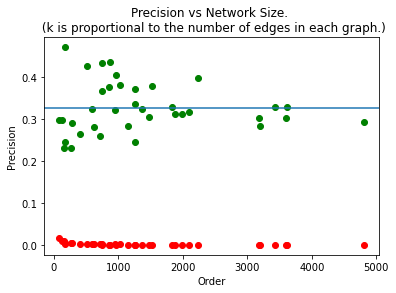

In [302]:
#[TP, FP, FN, TN]

def precision(x):
    return x[0]/(x[0]+x[1])

def random_precision(x):
    # Can calculate precision of random guessing analytically from hypergeometric distribution.
    K = np.floor(0.25*x[1])
    N = comb(x[0], 2) - x[1]
    TP = K**2/N
    FP = K-TP
    return (TP/(TP+FP))
    

keys = [x for x in test_order_Cmatrices.keys() if not test_order_Cmatrices[x][0]<10]

orders = [x[0] for x in keys]
precisions = [precision(test_order_Cmatrices[x]) for x in keys]
random_precisions = [random_precision(x) for x in keys]

# Plot precision
fig, axs = plt.subplots()
axs.scatter(orders, precisions, color="g")
axs.scatter(orders, random_precisions, color="r")
plt.axhline(y=np.mean(precisions))
axs.set_title("Precision vs Network Size. \n (k is proportional to the number of edges in each graph.)")
axs.set_xlabel("Order")
axs.set_ylabel("Precision")

## Test 2: Evaluate for differnet values of k on a single graph.

In [309]:
warnings.filterwarnings('ignore') # Ignore warnings.
    
# Connect to graph db.
dcon = sqlite3.connect("yt_graph.db")
    
# Init vertex list.
vertices = pd.Series([0], name="vertex")
whileBreak = 0
    
# Explode.
while len(vertices)<5000:
        
    # First, enlarge search by adding neighbors of the current subgraph.
    vertices.to_sql("vertexList", con=dcon, if_exists="replace")
    print("Executing SQL to expand target subgraph. (Initial vertex: " +
            str(0) + ")")
    neighbors = pd.read_sql_query(
    """
    SELECT DISTINCT
        x.v2
    FROM
        ytGraphUndirected x
    WHERE EXISTS (
        SELECT *
        FROM vertexList y
        WHERE y.vertex = x.v1
        OR y.vertex = x.v2
    )
    """, dcon)
    print("              SQL complete. Current size: " + str(len(vertices)))
    vertices = pd.Series(neighbors.squeeze(), name="vertex")
    whileBreak = whileBreak+1
    if whileBreak>20:
        break
        
# Turn vertices into a graph.
G_short = G_full.subgraph(list(vertices))

Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 1
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 10
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 48
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 195
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 198
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 225
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 266
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 347
Executing SQL to expand target subgraph. (Initial vertex: 0)
              SQL complete. Current size: 533
Executing SQL to expand target subgraph. 

In [316]:
# Make predictions on this graph.
preds = eval_model(G_short, 1, get_all_preds=True)

In [321]:
# Figure out which edges were removed because I'm dumb.
G_short_edges = [(min(edge), max(edge)) for edge in G_short.edges()]
removed_edges = [edge for edge in preds if edge in G_short_edges]

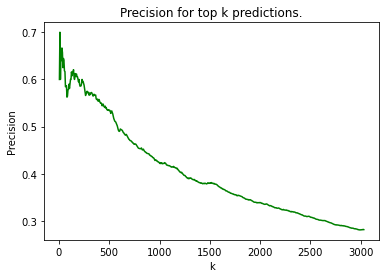

In [330]:
# Plot precision for different values of k.
xvals = np.linspace(start=5, stop=3030, num=606)
precs = []
for j in xvals:
    k = int(j)
    k_preds = preds[0:k]
    TP = len([edge for edge in k_preds if (edge in removed_edges)])
    FP = len(k_preds) - TP
    precs.append(TP/(TP+FP))
    
fig, axs = plt.subplots()
axs.plot(xvals, precs, color="g")
axs.set_title("Precision for top k predictions.")
axs.set_xlabel("k")
axs.set_ylabel("Precision")
plt.show()

In [331]:
# Save the items that took a long time to compute.

# G_short.
with open("test_results/G_short.pk", "wb") as file:
    pickle.dump(G_short, file)

# Prediction list for G_short.
with open("test_results/G_short_preds.pk", "wb") as file:
    pickle.dump(preds, file)
    
# Edges that were removed from G_short.
with open("test_results/G_short_removed_edges.pk", "wb") as file:
    pickle.dump(removed_edges, file)